In [1]:
!pip install imutils==0.5.3

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=7b7754cdf0655d07ef7935cfadbfdc1e4392b0fc14f251420b125ea79a18529d
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import FileLink
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(0)

import random
import shutil
import cv2
import os


In [3]:
dataset_path = './dataset'

## Build Dataset

In [4]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal

### Covid xray dataset

In [5]:
samples = 25

In [6]:
covid_dataset_path = '../input/covid-chest-xray'

In [7]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

### Build normal xray dataset

In [8]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [9]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

## Plot x-rays

Helper function to plot the images in a grid

In [10]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(20,10), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [11]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

In [12]:
normal_images

['./dataset/normal/NORMAL2-IM-1322-0001.jpeg',
 './dataset/normal/NORMAL2-IM-1293-0001.jpeg',
 './dataset/normal/IM-0375-0001.jpeg',
 './dataset/normal/IM-0199-0001.jpeg',
 './dataset/normal/NORMAL2-IM-0956-0001.jpeg',
 './dataset/normal/IM-0703-0001.jpeg',
 './dataset/normal/IM-0619-0001.jpeg',
 './dataset/normal/IM-0656-0001-0001.jpeg',
 './dataset/normal/IM-0664-0001.jpeg',
 './dataset/normal/IM-0668-0001.jpeg',
 './dataset/normal/IM-0478-0001.jpeg',
 './dataset/normal/IM-0262-0001.jpeg',
 './dataset/normal/NORMAL2-IM-1117-0001.jpeg',
 './dataset/normal/IM-0702-0001.jpeg',
 './dataset/normal/NORMAL2-IM-0599-0001.jpeg',
 './dataset/normal/NORMAL2-IM-0808-0001.jpeg',
 './dataset/normal/NORMAL2-IM-0486-0001.jpeg',
 './dataset/normal/NORMAL2-IM-0627-0001.jpeg',
 './dataset/normal/IM-0654-0001.jpeg',
 './dataset/normal/NORMAL2-IM-1006-0001.jpeg',
 './dataset/normal/NORMAL2-IM-0723-0001.jpeg',
 './dataset/normal/IM-0541-0001.jpeg',
 './dataset/normal/IM-0351-0001.jpeg',
 './dataset/normal

In [13]:
covid_images

['./dataset/covid/ryct.2020200034.fig5-day4.jpeg',
 './dataset/covid/CD50BA96-6982-4C80-AE7B-5F67ACDBFA56.jpeg',
 './dataset/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png',
 './dataset/covid/41591_2020_819_Fig1_HTML.webp-day10.png',
 './dataset/covid/lancet-case2a.jpg',
 './dataset/covid/nejmoa2001191_f5-PA.jpeg',
 './dataset/covid/16672_1_1.jpg',
 './dataset/covid/nejmc2001573_f1a.jpeg',
 './dataset/covid/covid-19-pneumonia-93.png',
 './dataset/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4b.png',
 './dataset/covid/2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg',
 './dataset/covid/F63AB6CE-1968-4154-A70F-913AF154F53D.jpeg',
 './dataset/covid/B2D20576-00B7-4519-A415-72DE29C90C34.jpeg',
 './dataset/covid/covid-19-pneumonia-7-PA.jpg',
 './dataset/covid/ryct.2020200028.fig1a.jpeg',
 './dataset/covid/2-chest-filmc.jpg',
 './dataset/covid/all14238-fig-0001-m-b.jpg',
 './dataset/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3b.png',
 './dataset/covid/1.CXRCTThora

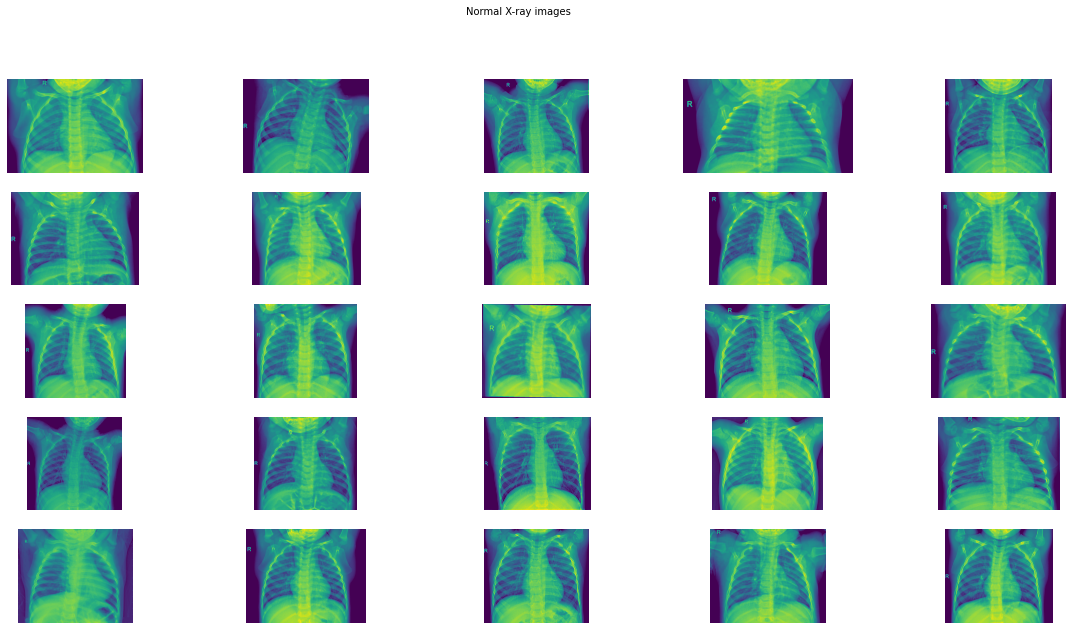

In [14]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

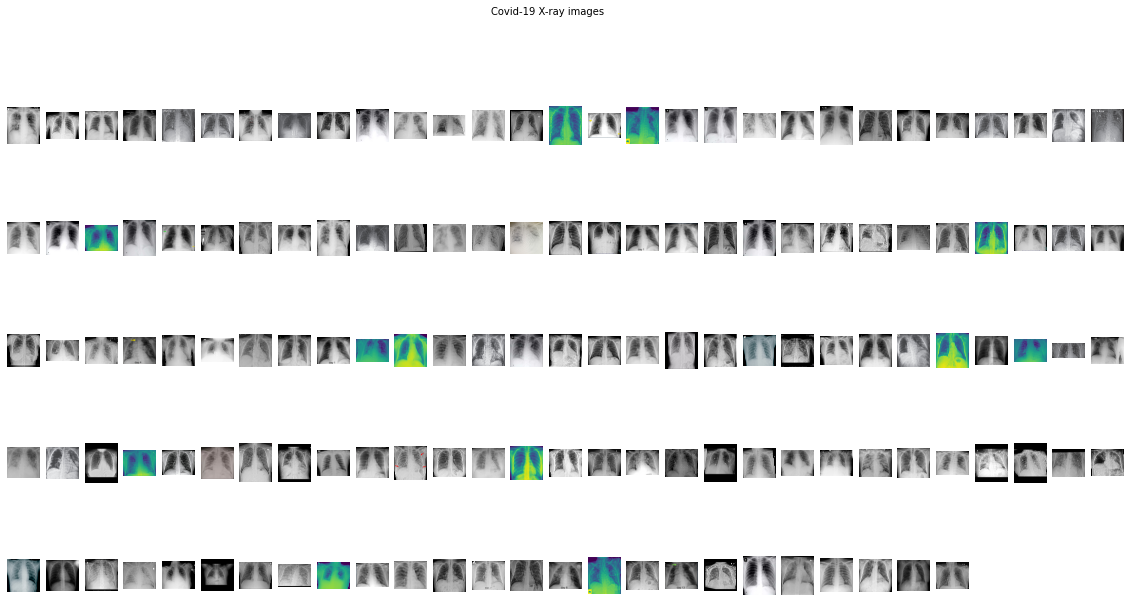

In [15]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

## Data preprocessing

In [16]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))

data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    image_np = (image).flatten()
    data.append(image_np)
    labels.append(label)
    
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data_train = np.array(data) / 255
labels_train = np.array(labels)

[INFO] loading images...


In [17]:
data

[array([ 40,  40,  40, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([  7,   7,   7, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   1,   1, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([ 49,  49,  49, ...,   0,   0, 255], dtype=uint8),
 array([ 68,  68,  68, ...,   0,   0, 255], dtype=uint8),
 array([110, 110, 110, ...,   0,   0, 255], dtype=uint8),
 array([  3,   3,   3, ...,   1,   1, 255], dtype=uint8),
 array([ 18,  18,  18, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([ 90,  90,  90, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([ 50,  50,  50, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([  0,  

In [18]:
len(data)

166

In [19]:
labels

['normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'cov

In [20]:
len(labels)

166

In [21]:
data_train

array([[0.15686275, 0.15686275, 0.15686275, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.21568627, 0.21568627, 0.21568627, ..., 0.        , 0.        ,
        1.        ],
       [0.04705882, 0.04705882, 0.04705882, ..., 0.09803922, 0.09803922,
        1.        ]])

In [22]:
labels_train

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid

In [23]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels_train_y = lb.fit_transform(labels_train)
labels_train_cat = to_categorical(labels_train_y)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing

(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)



In [24]:
X_train

[array([ 33,  33,  33, ..., 155, 155, 255], dtype=uint8),
 array([ 69,  69,  69, ...,  34,  34, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([ 90,  90,  90, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ..., 136, 136, 255], dtype=uint8),
 array([ 53,  53,  53, ..., 161, 161, 255], dtype=uint8),
 array([  0,   0,   0, ...,  44,  44, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([179, 179, 179, ..., 122, 122, 255], dtype=uint8),
 array([166, 166, 166, ..., 149, 149, 255], dtype=uint8),
 array([210, 212, 212, ...,  58,  58, 255], dtype=uint8),
 array([  0,   0,   0, ..., 206, 206, 255], dtype=uint8),
 array([ 95,  95,  95, ..., 120, 120, 255], dtype=uint8),
 array([  7,   7,   7, ...,   4,   4, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   0,   0, 255], dtype=uint8),
 array([  0,   0,   0, ...,   9,   9, 255], dtype=uint8),
 array([  0,  

In [25]:
y_train

['covid',
 'normal',
 'covid',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'normal',
 'covid',
 'covid',
 'normal',
 'covid',
 'covid',
 'covid',
 'normal',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'normal',
 'covid',
 'covid',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'normal',
 'covid',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'normal',
 'covid',
 'covid',
 'covid',
 'covi

## Comparison of Calibration of Classifiers

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve



# Create classifiers
lr = LogisticRegression(max_iter=10000)
gnb = GaussianNB()
svc = LinearSVC(C=1.0, max_iter=10000)
rfc = RandomForestClassifier()





# FIT MODELS

> /opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
>   "the number of iterations.", ConvergenceWarning)

In [27]:
LR_Model = lr.fit(X_train, y_train)


In [28]:
GNB_Model = gnb.fit(X_train, y_train)


In [29]:
SVC_Model = svc.fit(X_train, y_train)


In [30]:
RFC_Model = rfc.fit(X_train, y_train)

# Now save the model

In [31]:
import pickle

with open('LR_model.pkl', 'wb') as f1:
    pickle.dump(LR_Model,f1)
    f1.close()

with open('GNB_model.pkl', 'wb') as f2:
    pickle.dump(GNB_Model,f2)
    f2.close()

with open('SVM_model.pkl', 'wb') as f3:
    pickle.dump(SVC_Model,f3)
    f3.close()

with open('RF_model.pkl', 'wb') as f4:
    pickle.dump(RFC_Model,f4)
    f4.close()


    


In [32]:
from IPython.display import FileLink

FileLink(r'LR_model.pkl')


/kaggle/working/LR_model.pkl

In [33]:
FileLink(r'GNB_model.pkl')


/kaggle/working/GNB_model.pkl

In [34]:
FileLink(r'SVM_model.pkl')


/kaggle/working/SVM_model.pkl

In [35]:
FileLink(r'RF_model.pkl')

/kaggle/working/RF_model.pkl

# Metrics

In [36]:
from sklearn.metrics import accuracy_score


LR_y_pred = LR_Model.predict(X_test)
GNB_y_pred = GNB_Model.predict(X_test)
SVC_y_pred = SVC_Model.predict(X_test)
RFC_y_pred = RFC_Model.predict(X_test)


# accuracy_score(y_true, y_pred)


In [37]:
LR_acc_sc = accuracy_score(y_test, LR_y_pred)
LR_acc_sc

0.9705882352941176

In [38]:
GNB_acc_sc = accuracy_score(y_test, GNB_y_pred)
GNB_acc_sc

0.9705882352941176

In [39]:
SVC_acc_sc = accuracy_score(y_test, SVC_y_pred)
SVC_acc_sc

0.9705882352941176

In [40]:
RFC_acc_sc = accuracy_score(y_test, RFC_y_pred)
RFC_acc_sc

0.9705882352941176

In [41]:
print('LogisticRegression score: %f' % LR_Model.score(X_test, y_test))
print('Naive Bayes score: %f' % GNB_Model.score(X_test, y_test))
print('SVM score: %f' % SVC_Model.score(X_test, y_test))
print('Random Forest score: %f' % RFC_Model.score(X_test, y_test))

LogisticRegression score: 0.970588
Naive Bayes score: 0.970588
SVM score: 0.970588
Random Forest score: 0.970588


# Confusion Matrix

In [42]:
import itertools

In [43]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(8,8), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    savefilename = title+'.png'
        
    plt.savefig(savefilename)
    

In [44]:
cm_plot_labels = ['covid -ve','covid +ve']

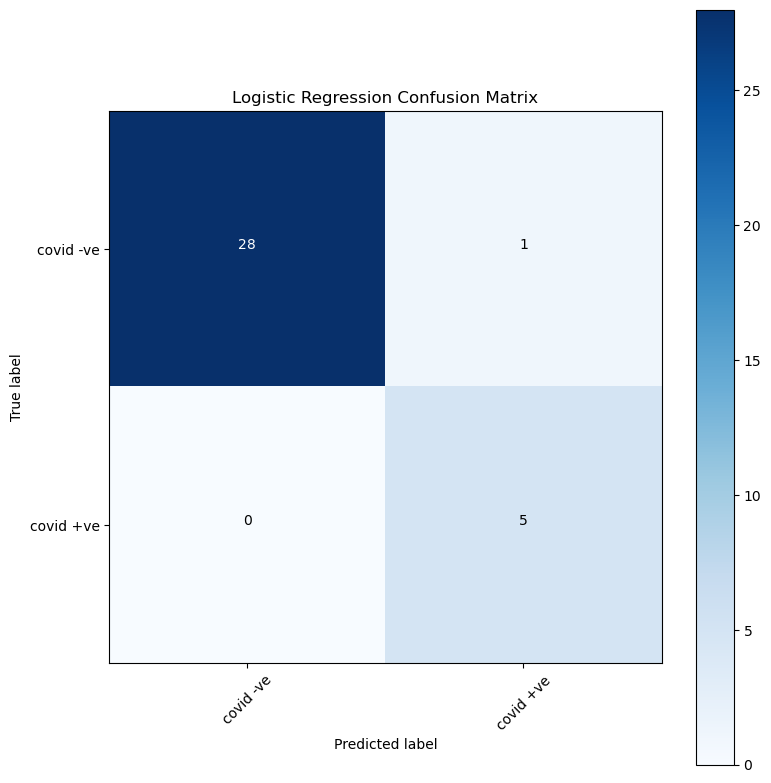

In [45]:
cm_lr = confusion_matrix(y_test, LR_y_pred)
plot_confusion_matrix(cm=cm_lr, classes=cm_plot_labels, title='Logistic Regression Confusion Matrix')


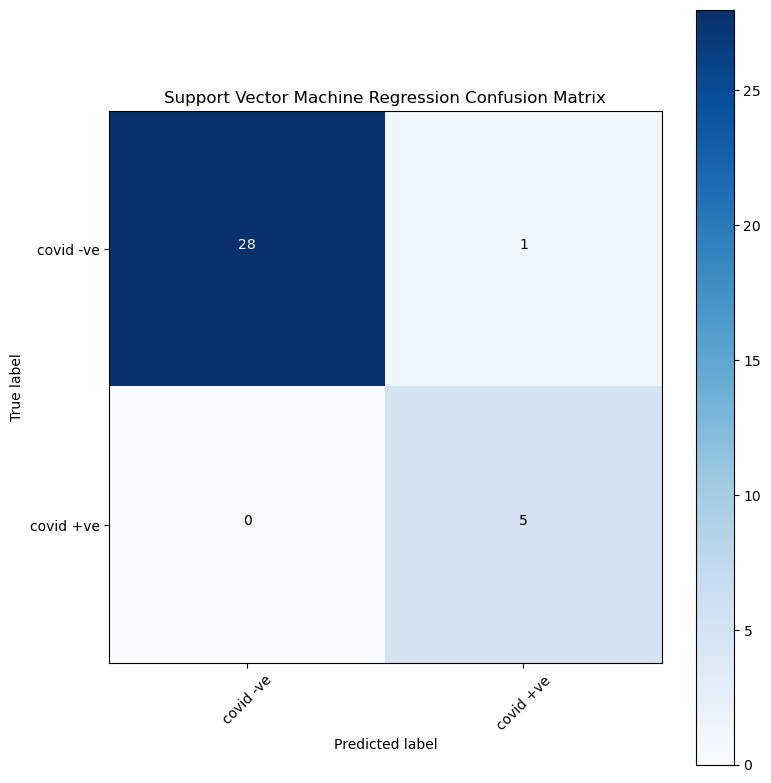

In [46]:
cm_nb = confusion_matrix(y_test, GNB_y_pred)
plot_confusion_matrix(cm=cm_lr, classes=cm_plot_labels, title='Support Vector Machine Regression Confusion Matrix')


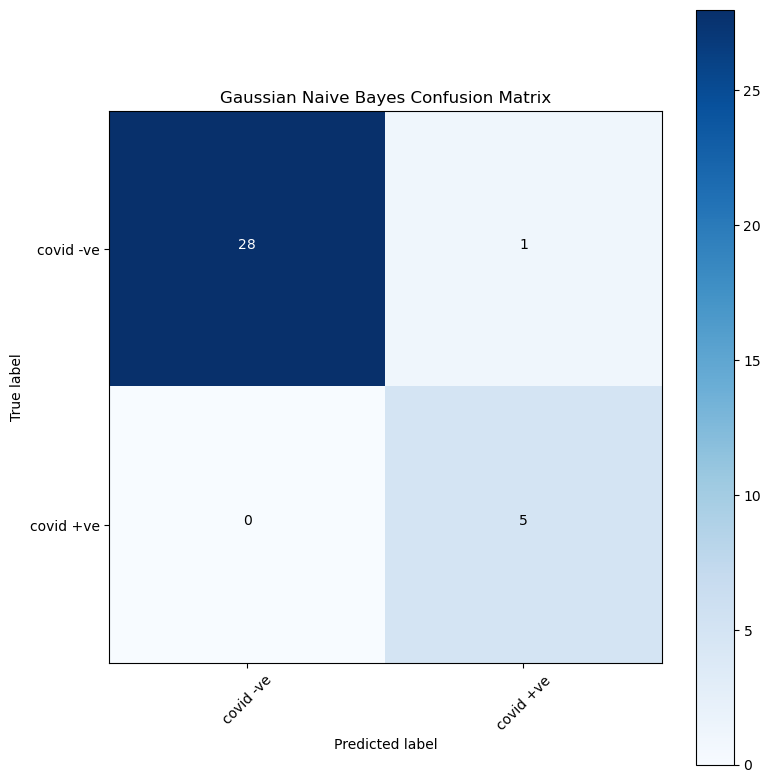

In [47]:
cm_svc = confusion_matrix(y_test, SVC_y_pred)
plot_confusion_matrix(cm=cm_nb, classes=cm_plot_labels, title='Gaussian Naive Bayes Confusion Matrix')


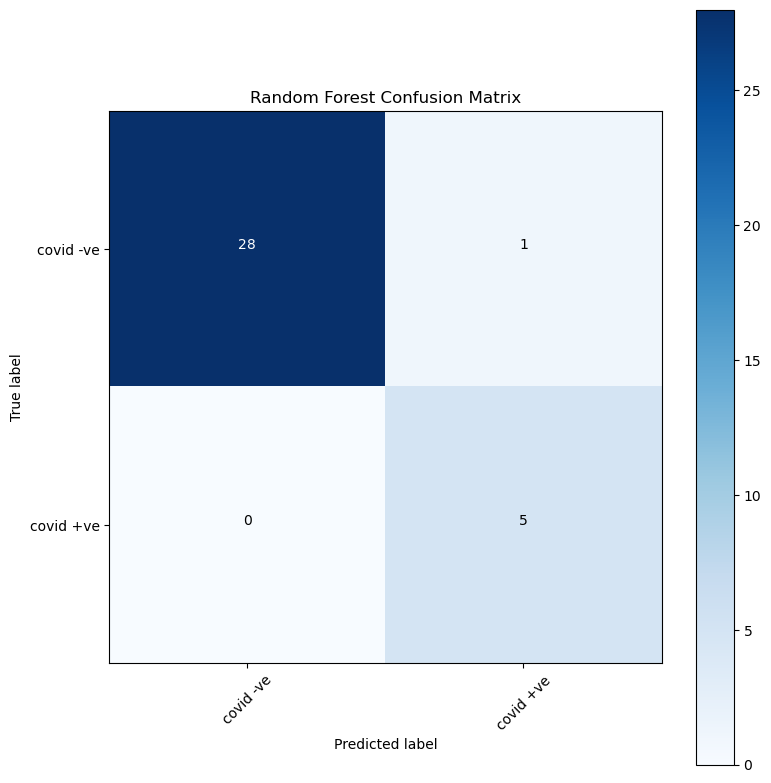

In [48]:
cm_rf = confusion_matrix(y_test, RFC_y_pred)
plot_confusion_matrix(cm=cm_rf, classes=cm_plot_labels, title='Random Forest Confusion Matrix')


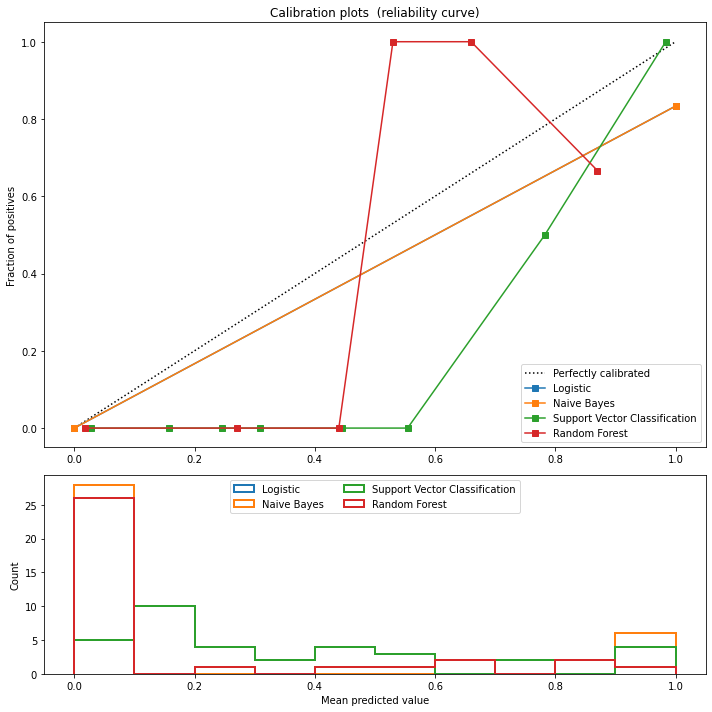

In [49]:
# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()


Test on covid image:

In [50]:
import os

files = os.listdir("../input/covid-chest-xray/images")
covid_final = 0
normal_final = 0


for i in files:
    dir = "../input/covid-chest-xray/images" + "/" + i
    test_image = cv2.imread(dir)
    #print(dir)
    test_image = cv2.cvtColor(test_image, cv2.IMREAD_GRAYSCALE)
    test_image = cv2.resize(test_image, (224, 224))
    test_img = test_image.flatten().reshape(1, -1)


    result= [LR_Model.predict(test_img), GNB_Model.predict(test_img), SVC_Model.predict(test_img), RFC_Model.predict(test_img)]
    
    #print(result)

    occ = []
 
    for i in result:
        occ.append(result.count(i))
    
    if result[occ.index(max(occ))] == "covid":
        covid_final += 1
        print("covid")
    else:
        normal_final += 1
        print("normal")



covid
covid
normal
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
normal
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
normal
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
co

In [51]:
print("covid" , covid_final)
print("normal", normal_final)

covid 332
normal 25


In [52]:
covid = [0] * 4 
normal = [0] * 4

In [53]:
import os

files = os.listdir("../input/covid-chest-xray/images")

for i in files:
    dir = "../input/covid-chest-xray/images" + "/" + i
    test_image = cv2.imread(dir)
    #print(dir)
    test_image = cv2.cvtColor(test_image, cv2.IMREAD_GRAYSCALE)
    test_image = cv2.resize(test_image, (224, 224))
    test_img = test_image.flatten().reshape(1, -1)


    result= RFC_Model.predict(test_img)
    
    if result == "covid":
        covid[3] += 1
        print("covid")
    else:
        normal[3] += 1
        print("normal")
    

covid
covid
normal
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
normal
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
normal
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
normal
covid
covid
covid
covid
normal
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
normal
covid
covid
covid
covid
covid
covid
normal
covid
covid

In [54]:
print(covid)
print(normal)

[0, 0, 0, 328]
[0, 0, 0, 29]


In [55]:
data = {'Algorithms':["Logistic Regression", "Naive Bayes", "Support Vector Classifier", "Random Forest Classifier"],
       'Covid':covid,
       'Normal':normal}

df = pd.DataFrame(data, columns = ['Algorithms', 'Covid', 'Normal'])

print(df)

                  Algorithms  Covid  Normal
0        Logistic Regression      0       0
1                Naive Bayes      0       0
2  Support Vector Classifier      0       0
3   Random Forest Classifier    328      29


Test on normal image:

In [56]:


test_image = cv2.imread('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0003-0001.jpeg')
test_image = cv2.cvtColor(test_image, cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (224, 224))
test_img = test_image.flatten().reshape(1, -1)


result= [LR_Model.predict(test_img), GNB_Model.predict(test_img), SVC_Model.predict(test_img), RFC_Model.predict(test_img)]

occ = []
 
for i in result:
    occ.append(result.count(i))
    
print(result[occ.index(max(occ))])
        



['normal']
